In [1]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute, transpile, Aer, IBMQ # circuit creation and execution
from qiskit.providers.aer.noise import NoiseModel # simulate backends
from qiskit.visualization import plot_histogram # visualize results
from qiskit.quantum_info import Statevector, state_fidelity, hellinger_fidelity # statevector and metrics
from qiskit.providers.ibmq import least_busy # get least busy device
import qiskit.tools.jupyter # visualize backends
from qiskit.circuit.library.standard_gates.rx import RXGate
# from qiskit.ignis.mitigation.measurement import complete_meas_cal,CompleteMeasFitter # measurement error mitigation

import pandas as pd # handy tools for calculation
from numpy import pi

# global vars
n = 3 # number of qubits
shots = 1000 # high number of shots per execution

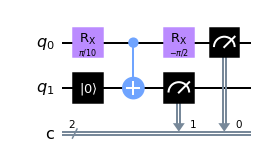

In [2]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.rx(pi*1/10, qreg_q[0])
circuit.reset(qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.rx(-pi/2, qreg_q[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[0], creg_c[0])
circuit.draw(output='mpl')

In [3]:
print(circuit.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
rx(pi/10) q[0];
reset q[1];
cx q[0],q[1];
rx(-pi/2) q[0];
measure q[1] -> c[1];
measure q[0] -> c[0];



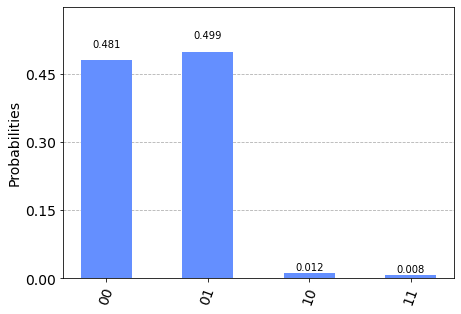

In [4]:
# Running the basic bomb tester circuit

from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

job = simulator.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts(circuit)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [5]:
expected_states = ['00', '01', '10', '11']  # target states

def get_state_accuracy(counts): # funciton to calculate state accuracy
    expected_counts = 0
    for state in counts.keys():
        if state in expected_states:
            expected_counts = expected_counts + counts[state]
    state_accuracy = expected_counts / shots
    return str(state_accuracy*100)+"%"

In [6]:
counts = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shots=shots).result().get_counts() # execution on simulator
state_accuracy = get_state_accuracy(counts)
print(f"state accuracy on the simulator: {state_accuracy}")

state accuracy on the simulator: 100.0%


In [7]:
from qiskit.test.mock import *

backends = [FakeVigo()]

In [8]:
backend1 = FakeVigo()

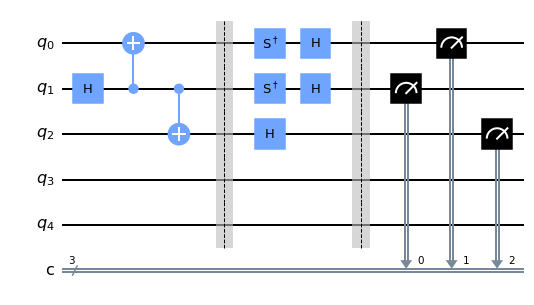

In [9]:
# backend1: create coupling map optimised circuit

# map: qubit 0 -> qubit 1
# qubit 1 -> qubit 0
# qubit 2 -> qubit 2

circuit_backend1 = QuantumCircuit(5,3, name=f"GHZ yyx {backend1.name()} optimized") # note that we use 5 qubits here to match the configuration of the device
circuit_backend1.h(1) # we map qubit 0 to qubit 1 and qubit 1 to qubit 0 ..
circuit_backend1.cx(1,0) # .. to ensure that all logical CNOT gates are performed on physical connections
circuit_backend1.cx(1,2)
circuit_backend1.barrier()
circuit_backend1.sdg([1,0]) 
circuit_backend1.h(range(n))
circuit_backend1.barrier()
circuit_backend1.measure([1,0,2], range(n))
circuit_backend1.draw("mpl")

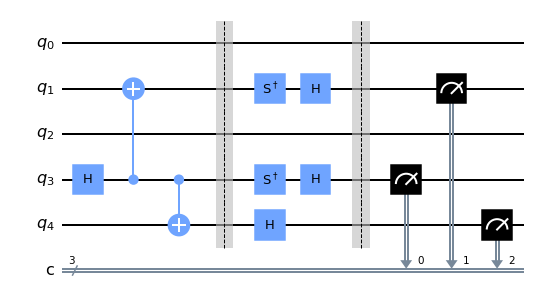

In [10]:
# backend1: create coupling map + error rate optimised circuit

# map: qubit 0 -> qubit 3
# qubit 1 -> qubit 1
# qubit 2 -> qubit 4

circuit_backend1_error = QuantumCircuit(5,3, name=f"GHZ yyx {backend1.name()} error rate optimised") # note that we use 5 qubits here to match the configuration of the device
circuit_backend1_error.h(3) # qubit with best adjacent multi-qubit gates error rates (cnot)
circuit_backend1_error.cx(3,1)
circuit_backend1_error.cx(3,4) 
circuit_backend1_error.barrier()
circuit_backend1_error.sdg([3,1]) # avoid 4 as it has a worse single qubit error rate
circuit_backend1_error.h([3,1,4]) # best readout error rates
circuit_backend1_error.barrier()
circuit_backend1_error.measure([3,1,4], range(n)) # readout still in same order
circuit_backend1_error.draw("mpl")

State Accuracy 
optimization_level_0: 100.0%
optimization_level_1: 100.0%
optimization_level_2: 100.0%
optimization_level_3: 100.0%


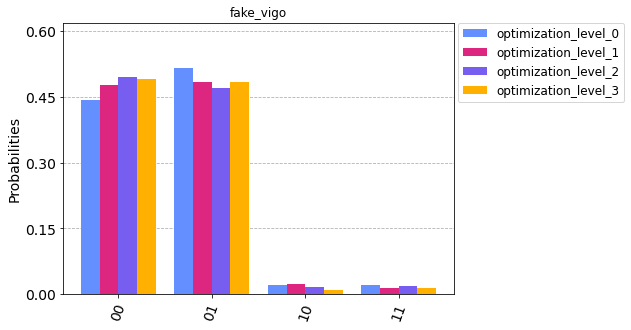

In [11]:
# compare results from different optimization levels on backend 1
results_backend1_transpiler = []

optimization_levels = [0,1,2,3]
#print(ghz)
for optim_level in optimization_levels:
    transpiled_circuit = transpile(circuit, backend=backend1, optimization_level=optim_level)
    #print(transpiled_circuit)
    counts = execute(circuit, backend=backend1, shots=shots, optimization_level=optim_level).result().get_counts() # get results
    state_accuracy = get_state_accuracy(counts) # calculate state accuracy
    results_backend1_transpiler.append((optim_level, counts, state_accuracy)) # store
    
# compare state accuracies
print("State Accuracy \n"+
      "\n".join(["optimization_level_"+str(optim_level)+': '+str(state_accuracy) 
                 for optim_level, counts, state_accuracy in results_backend1_transpiler]))

# plot results
plot_histogram([counts for optim_level, counts, state_accuracy in results_backend1_transpiler],
               legend=["optimization_level_"+str(optim_level) for optim_level, counts, state_accuracy in results_backend1_transpiler],
               title=backend1.name(),
               bar_labels=False)

In [12]:
# compare transpiled circuits for different optimization levels on backend 1

optimization_levels = [0,1,2,3]
print("original circuit")
print(circuit)
for optim_level in optimization_levels:
    print(f"optimization level: {optim_level}")
    transpiled_circuit = transpile(circuit, backend=backend1, optimization_level=optim_level)
    print(transpiled_circuit)

original circuit
     ┌──────────┐     ┌──────────┐┌─┐
q_0: ┤ Rx(π/10) ├──■──┤ Rx(-π/2) ├┤M├
     └──────────┘┌─┴─┐└───┬─┬────┘└╥┘
q_1: ────|0>─────┤ X ├────┤M├──────╫─
                 └───┘    └╥┘      ║ 
c: 2/══════════════════════╩═══════╩═
                           1       0 
optimization level: 0
global phase: π
               ┌─────────┐┌────┐┌────────────┐┌────┐┌──────────┐     »
      q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(11π/10) ├┤ √X ├┤ Rz(5π/2) ├──■──»
               └─────────┘└────┘└────────────┘└────┘└──────────┘┌─┴─┐»
      q_1 -> 1 ────|0>──────────────────────────────────────────┤ X ├»
                                                                └───┘»
ancilla_0 -> 2 ──────────────────────────────────────────────────────»
                                                                     »
ancilla_1 -> 3 ──────────────────────────────────────────────────────»
                                                                     »
ancilla_2 -> 4 ─────────────────────────

In [13]:
print("manual optimization")
print(circuit_backend1_error)

print("State Accuracy")
print("manual optimization:  "+str(results_backend1_error[0][2]))
print("transpiler optimization: "+str(results_backend1_transpiler[3][2]))

manual optimization
                     ░              ░          
q_0: ────────────────░──────────────░──────────
          ┌───┐      ░ ┌─────┐┌───┐ ░    ┌─┐   
q_1: ─────┤ X ├──────░─┤ Sdg ├┤ H ├─░────┤M├───
          └─┬─┘      ░ └─────┘└───┘ ░    └╥┘   
q_2: ───────┼────────░──────────────░─────╫────
     ┌───┐  │        ░ ┌─────┐┌───┐ ░ ┌─┐ ║    
q_3: ┤ H ├──■────■───░─┤ Sdg ├┤ H ├─░─┤M├─╫────
     └───┘     ┌─┴─┐ ░ └┬───┬┘└───┘ ░ └╥┘ ║ ┌─┐
q_4: ──────────┤ X ├─░──┤ H ├───────░──╫──╫─┤M├
               └───┘ ░  └───┘       ░  ║  ║ └╥┘
c: 3/══════════════════════════════════╩══╩══╩═
                                       0  1  2 
State Accuracy


NameError: name 'results_backend1_error' is not defined